# Demo of do_bins and hist_2d functions in fastbin.pyx

# To dowload notebook and code:

git clone [https://github.com/phaustin/hist2d.git](https://github.com/phaustin/hist2d.git)

# To view the notebook: 

[http://nbviewer.ipython.org/github/phaustin/hist2d/blob/master/hist2d.ipynb?create=1](http://nbviewer.ipython.org/github/phaustin/hist2d/blob/master/hist2d.ipynb?create=1)

# Cython code: fastbin.pyx

```cython
import numpy as np
cimport numpy as np
from libc.stdint cimport int32_t
cimport cython
from libc.stdio cimport printf

@cython.embedsignature(True)
@cython.cdivision(True)
@cython.wraparound(False)
@cython.boundscheck(False)
def do_bins(object data_vec,int the_numbins,float mindata,\
            float maxdata,\
            int missingLow= -200,int missingHigh= -100):
    """
       bin the items in data_vec into numbins
       see binit docstring for details

       parameters
       ----------

        data_vec: numpy 1d array or list
             vector of floating point numbers to be binned

        the_numbins: number of bins
        mindata:     value of leftmost edge of the bins
        maxdata:     value of rightmost edge of the bins
        missingLow   bin index assigned to data smaller than mindata
                      (must be negative)
        missingHigh  bin index assigned to data larger than maxdatat
                      (must be negative)
       returns:
       --------

         dictionary with the following keys:

         bin_count: numpy vector of length numbins (int)
            vector containing bin counts

         bin_index: numpy vector of len(data_vec)
            vector containing the bin number of each datapoint

         lowcount: int
            number of points that were smaller
            than the smallest bin

         highcount: int
            number of points that were larger than the largest
            bin

         data_vec: ndarray of the data that was binned 
    
       example
       -------
             #bin a temperature vector into 20 1K  bins
             #starting at 270.
             bin_dict=obj.do_bins(temp_vec,20,270.,300.)
    """   
    data_vec=np.ascontiguousarray(data_vec)
    data_vec=data_vec.astype(np.float64)
    cdef double* dataPtr= <double*> np.PyArray_DATA(data_vec)
    cdef double binsize=(maxdata-mindata)/float(the_numbins)
    cdef np.int32_t[:] bin_index=np.empty([data_vec.size],dtype=np.int32)
    cdef np.int32_t[:] bin_count=np.zeros([the_numbins],dtype=np.int32)
    cdef int lowcount=0, highcount=0,tot_loops=data_vec.size
    cdef int i
    cdef double float_bin,data_val
    cdef int ibin
    cdef double minval=mindata
    cdef int missingLowValue=missingLow
    cdef int missingHighValue =missingHigh
    cdef int numbins=the_numbins
    cdef double dataval

    for i in range(tot_loops):
        dataval=dataPtr[i]
        float_bin =  ((dataval - minval) /binsize)
        if float_bin < 0:
            lowcount+=1
            bin_index[i]=missingLowValue
            continue
        if float_bin > numbins:
            highcount += 1
            bin_index[i] = missingHighValue
            continue
        ibin=<int> float_bin
        bin_count[ibin]+=1
        bin_index[i]=ibin

    bin_edges=[]
    bin_centers=[]
    bin_edges=[minval + (i*binsize) for i in range(numbins+1)]
    bin_centers=[(bin_edges[i] + bin_edges[i+1])/2. for i in range(numbins)]
    bin_edges=np.array(bin_edges)
    bin_centers=np.array(bin_centers)
    out_dict=dict(bin_count=np.asarray(bin_count),bin_index=np.asarray(bin_index),
                  bin_edges=bin_edges,bin_centers=bin_centers,numbins=the_numbins,
                  lowcount=lowcount,highcount=highcount,data_vec=data_vec)
    return out_dict

def hist_2d(dict bin_xvals,dict bin_yvals):
    """
       calculate the 2-d histogram given two dictionaries produced by
       calls to fastbin.do_bins  

       parameters
       ----------

        bin_xvals: dictionary with bin_index vector from do_bins containing
                   the bin index for each datapoint and the number of
                   bins numbins

        bin_yvals: as for bin_xvals, but for the yvalues for the histogram

       returns:
       --------

         dictionary with the following keys:

            index_grid: numpy object array with shape [numbinsx,numbinsy] containing the
                     lists of datapoints that were binned into each bin

            count_grid: numpy float32 array with shape [numbinsx,numbinsy] containing the
                     counts in each bin

       example
       -------

             #bin a temperature vector into 20 1K  bins
             #starting at 270.
             bin_dict=obj.do_bins(temp_vec,20,270.,300.)
    """   
    
    out_vals=np.empty([bin_yvals['numbins'],bin_xvals['numbins']],dtype=np.object)
    x_index=bin_xvals['bin_index']
    y_index=bin_yvals['bin_index']
    xvals=bin_xvals['data_vec']
    yvals=bin_yvals['data_vec']

    cdef int numybins=bin_yvals['numbins']
    cdef int numxbins=bin_xvals['numbins']
    cdef int num_datapts=<int> y_index.size
    cdef int row,col, data_index, grid_row,grid_col,rows,cols

    cdef int[:] y_view=y_index
    cdef int[:] x_view=x_index
    
    for row in range(numybins):
        for col in range(numxbins):
            out_vals[row,col]=list()

    for data_index in range(num_datapts):
        grid_row=y_index[data_index]
        grid_col=x_index[data_index]
        if grid_row < 0 or grid_col < 0:
            continue
        else:
            out_vals[grid_row,grid_col].append(data_index)

    #
    # use float32 for counts so we can use np.nan
    # for plotting
    #
    cdef float[:,:] count_grid=np.empty_like(out_vals,dtype=np.float32)
    rows,cols=out_vals.shape

    for row in range(rows):
        for col in range(cols):
            data_list=out_vals[row,col]
            if len(data_list)==0:
                count_grid[row,col]=np.nan
            else:
                count_grid[row,col]=len(data_list)
    out_dict=dict(index_grid=out_vals,count_grid=np.asarray(count_grid))

    return out_dict
```

# setup.py

```python
from distutils.core import setup
from distutils.extension import Extension
from Cython.Distutils import build_ext
import numpy

ext_modules = [Extension('fastbin', ['fastbin.pyx'],
                       include_dirs = [numpy.get_include()],
                       extra_compile_args=['-O3', '-fPIC'],
                       library_dirs=['.'],
                       language="c++")]

setup(name        = 'fastbin',
      cmdclass    = {'build_ext': build_ext},
      ext_modules = ext_modules
      )
```

In [1]:
!python setup.py build_ext --inplace

running build_ext
skipping 'fastbin.cpp' Cython extension (up-to-date)


# test_bin.py: create a dataset that is the sum of two 2D gaussians using makeRandom:

In [2]:
a=5
b=6*a
print(a)

5


In [3]:
import numpy.random as nr
def makeRandom(meanx=None,stdx=None,meany=None,stdy=None,rho=None,
               numpoints=4000):
    """
        return a tuple with two vectors (xvec,yvec) giving the
        coordinates of numpoints chosen from a two dimensional
        Gauassian distribution

        Parameters
        ----------

        meanx: float -- mean in x direction
        stdx:  float -- standard deviation in x direction
        meany: float -- mean in y direction
        stdy:  float -- standar deviation in y direction
        numpoints:  length of returned xvec and yvec
        

        Returns
        -------

        (xvec, yvec): tuple of ndarray vectors of length numpoints

        Example
        -------

        invalues={'meanx':450.,
                  'stdx':50,
                  'meany':-180,
                  'stdy':40,
                  'rho':0.8}

        chanx,chany=makeRandom(**invalues)
        

    """
 
    nr.seed(50)
    sigma=np.array([stdx**2., rho*stdx*stdy, rho*stdx*stdy, stdy**2.])
    sigma.shape=[2,2]
    meanvec=[meanx,meany]
    outRandom=nr.multivariate_normal(meanvec,sigma,[numpoints,])
    chan1=outRandom[:,0]
    chan2=outRandom[:,1]
    return (chan1,chan2)


Use this to create an x vector and a y vector to histogram

In [4]:
#
# first bullseye centered at (x=450,y= -180)
#
invalues={'meanx':450.,
          'stdx':50,
          'meany':-180,
          'stdy':40,
          'rho':0.8}


chanx,chany=makeRandom(**invalues)

#
# second bullseye centered at (x=50,y=-80)
#
bullseye={'meanx':50.,
          'stdx':14,
          'meany':-80,
          'stdy':14,
          'rho':0.0}

chanxB,chanyB=makeRandom(**bullseye)
chanx=np.concatenate((chanx,chanxB))
chany=np.concatenate((chany,chanyB))


Here is the scatterplot:

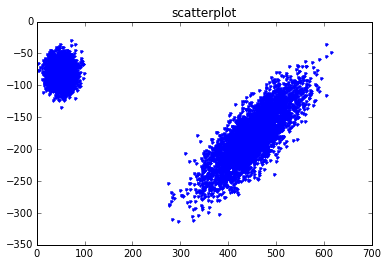

In [5]:
%matplotlib inline
fig1=plt.figure(1)
fig1.clf()
axis1=fig1.add_subplot(111)
axis1.plot(chanx,chany,'b.')
axis1.set_title('scatterplot')
fig1.canvas.draw()
fig1.savefig('scatter.png')

now bin these two channels

In [6]:
from fastbin import do_bins,hist_2d

In [7]:
bin_x=do_bins(chanx,70,0,700,-999,-888)
bin_y=do_bins(chany,50,-400,0,-999,-888)


In [8]:
bin_x.keys()

dict_keys(['data_vec', 'bin_centers', 'bin_index', 'highcount', 'lowcount', 'bin_edges', 'numbins', 'bin_count'])

In [9]:
x_centers=bin_x['bin_centers']
y_centers=bin_y['bin_centers']
the_hist=hist_2d(bin_x,bin_y)

In [10]:
the_hist.keys()

dict_keys(['count_grid', 'index_grid'])

plot the counts

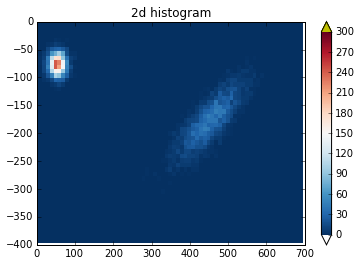

In [11]:
from matplotlib import cm
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt

the_hist=hist_2d(bin_x,bin_y)
counts=the_hist['count_grid']
cmap=cm.RdBu_r
cmap.set_over('y')
cmap.set_under('w')
vmin= 0.
vmax= 300.
the_norm=Normalize(vmin=vmin,vmax=vmax,clip=False)

fig3=plt.figure(1)
fig3.clf()
axis1=fig3.add_subplot(111)
im=axis1.pcolormesh(x_centers,y_centers,counts,cmap=cmap,norm=the_norm)
cb=fig3.colorbar(im,extend='both')
axis1.set_title('2d histogram')
fig3.canvas.draw()
fig3.savefig('histogram.png')


In [6]:
col_bins=np.linspace(0,700,70)
row_bins=np.linspace(-400,0,50)

In [7]:
col_indices=np.searchsorted(col_bins,chanx.flat,'right')
row_indices=np.searchsorted(row_bins,chany.flat,'right')

In [8]:
from hist_numba import numba_hist2d
from importlib import reload
import hist_numba
reload(hist_numba)

<module 'hist_numba' from '/Users/phil/repos/pythonlibs/hist2d/hist_numba.py'>

In [9]:
hist_array,x_centers,y_centers=numba_hist2d(chanx.ravel(),chany.ravel(),col_bins,row_bins)

in numba


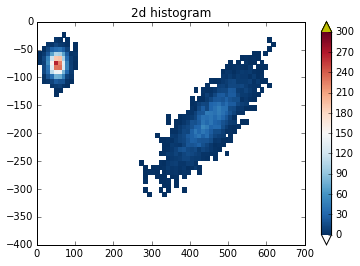

In [16]:
fig3=plt.figure(1)
axis1=fig3.add_subplot(111)
mask=np.isnan(hist_array)
hist_array=np.ma.array(hist_array,mask=mask)
im=axis1.pcolormesh(x_centers,y_centers,hist_array,cmap=cmap,norm=the_norm)
cb=fig3.colorbar(im,extend='both')
axis1.set_title('2d histogram')
